# REDDIT 5k

# Read and parse the dataset

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
# which graph each node belongs
graph_idx = pd.read_csv("datasets/REDDIT-MULTI-5K/REDDIT-MULTI-5K_graph_indicator.txt", 
                        names=["graph_idx"], header=None)
graph_idx.index = np.arange(1, len(graph_idx)+1)
graph_idx.index.rename('node_id', inplace=True)
graph_idx

,graph_idx
node_id,
1,1
2,1
3,1
4,1
5,1
...,...
2542067,4999
2542068,4999
2542069,4999


In [3]:
# each graph class (1 to 5)
graph_classes = pd.read_csv("datasets/REDDIT-MULTI-5K/REDDIT-MULTI-5K_graph_labels.txt", 
                            names=["label"], header=None)
graph_classes.index = np.arange(1, len(graph_classes)+1)
graph_classes.index.rename('graph_id', inplace=True)
graph_classes

,label
graph_id,
1,1
2,1
3,1
4,1
5,1
...,...
4995,2
4996,2
4997,2


In [4]:
# edge list
graph_edges = pd.read_csv("datasets/REDDIT-MULTI-5K/REDDIT-MULTI-5K_A.txt", 
                          names=["n1", "n2"], header=None)
#graph_edges.index.rename('graph_id', inplace=True)
graph_edges

,n1,n2
0,1,468
1,468,1
2,2,248
3,248,2
4,3,636
...,...,...
11895107,2541982,2542070
11895108,2542070,2542012
11895109,2542012,2542070
11895110,2542071,2542060


## For each graph, save its edges in a separate file

In [5]:
# create a dict to store the adj list of each graph
graphs_dict = graph_classes.to_dict(orient='index')
for key in graphs_dict:
    graphs_dict[key]['edges'] = []

In [6]:
len(graph_edges)

11895112

In [7]:
for row in tqdm(graph_edges.itertuples()):
    graphs_dict[graph_idx.loc[row[1]][0]]['edges'].append([row.n1, row.n2])

11895112it [1:13:24, 2700.87it/s]


In [8]:
!mkdir datasets/REDDIT-MULTI-5K/edges

In [10]:
for key in graphs_dict:
    adj_list = np.array(graphs_dict[key]['edges'])
    np.savetxt('datasets/REDDIT-MULTI-5K/edges/{}.edges'.format(key), ecc, delimiter=',')    

NameError: name 'ecc' is not defined

In [11]:
import pickle

pickle.dump( graphs_dict, open( "graphs_dict_5k.pkl", "wb" ) )

# Assign filtration and compute ECC

In [1]:
!mkdir datasets/REDDIT-MULTI-5K/ECC

mkdir: ECC: File exists


In [1]:
import networkx as nx
import gudhi as gd
import numpy as np
import pandas as pd

import ecc_graphs

# Compute the ECC

In [ ]:
for idx in range(1,5000):
    # create graph
    G=nx.read_edgelist('datasets/REDDIT-MULTI-5K/edges/{}.edges'.format(idx), delimiter=',')
    
    # add filtration values
    for node in G.nodes:
        G.nodes[node]['weight'] = nx.degree(G, node)
    
    for edge in G.edges:
        degrees = [d[1] for d in nx.degree(G, edge)]
        G.edges[edge]['weight'] = max(degrees)
        
    # create simplicial complex from graph
    simplex_tree = gd.SimplexTree()

    create_flag = True

    if create_flag:
        # insert higher dim simplicies
        for clique_list in nx.find_cliques(G):
            # convert from string to int
            clique = [int(v) for v in clique_list]
            simplex_tree.insert(clique, filtration=max([G.nodes[str(node)]['weight'] for node in clique]))
    else:
        # insert only nodes and edges
        for node in G.nodes.data('weight'):
            simplex_tree.insert([int(node[0])], filtration=node[1])
        for edge in G.edges.data('weight'):
            simplex_tree.insert([int(edge[0]), int(edge[1])], filtration=edge[2])
        
    # compute ECC
    c_list, num_simplicies = ecc_graphs.compute_local_contributions(simplex_tree)
    ecc = ecc_graphs.euler_characteristic_list(c_list)
    
    # save ECC
    np.savetxt('datasets/REDDIT-MULTI-5K/ECC/ecc_{}.csv'.format(idx), ecc, delimiter=',')

# Plot some of them

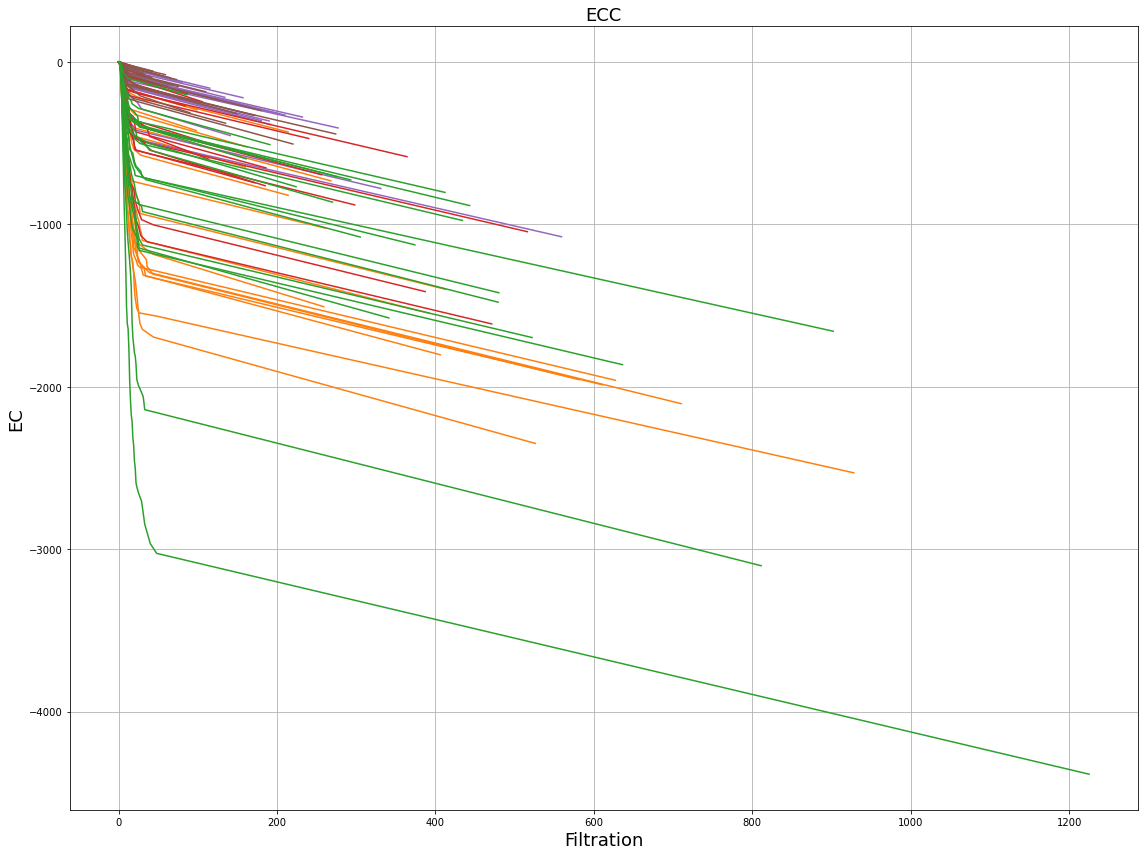

In [6]:
from matplotlib import pyplot as plt

# Plot ECC
plt.close('all')
plt.figure(figsize=(16,12))

cmap = plt.get_cmap("tab10")

for idx in range(1, 5000, 50):
    data = np.loadtxt('datasets/REDDIT-MULTI-5K/ECC/ecc_{}.csv'.format(idx), delimiter=',')
    
    plt.plot(data[:, 0], data[:, 1], 
                 label='{}'.format(idx),
                 color = cmap(graph_classes.loc[idx].label))

plt.xlabel('Filtration', fontsize=18)
plt.ylabel('EC', fontsize=18)
plt.title('ECC', fontsize=18)
plt.grid()
#plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig("CV_eta.pdf")
# files.download("CV_eta.pdf")
plt.show()

# Create Dataset

In [6]:
# each graph class (1 to 5)
graph_classes = pd.read_csv("REDDIT-MULTI-5K.graph_labels", names=["label"], header=None)
graph_classes.index.rename('graph_id', inplace=True)
graph_classes

,label
graph_id,
0,1
1,1
2,1
3,1
4,1
...,...
4994,2
4995,2
4996,2


In [13]:
ECC_list = []

for idx in range(1,5000):
    # create graph
    G=nx.read_edgelist('edges/{}.edges'.format(idx), delimiter=',')
    
    # compute max degree
    max_degree = max([d[1] for d in G.degree()])
    
    # add filtration values
    for node in G.nodes:
        G.nodes[node]['weight'] = nx.degree(G, node)/max_degree
    
    for edge in G.edges:
        degrees = [d[1] for d in nx.degree(G, edge)]
        G.edges[edge]['weight'] = max(degrees) / max_degree
        
    # create simplicial complex from graph
    simplex_tree = gd.SimplexTree()

    create_flag = True

    if create_flag:
        # insert higher dim simplicies
        for clique_list in nx.find_cliques(G):
            # convert from string to int
            clique = [int(v) for v in clique_list]
            simplex_tree.insert(clique, filtration=max([G.nodes[str(node)]['weight'] for node in clique]))
    else:
        # insert only nodes and edges
        for node in G.nodes.data('weight'):
            simplex_tree.insert([int(node[0])], filtration=node[1])
        for edge in G.edges.data('weight'):
            simplex_tree.insert([int(edge[0]), int(edge[1])], filtration=edge[2])
        
    # compute ECC
    c_list, num_simplicies = ecc_graphs.compute_local_contributions(simplex_tree)
    ecc = ecc_graphs.euler_characteristic_list(c_list)
    
    # save ECC divided by number of nodes
    ecc[:,1] = ecc[:,1] / len(G.nodes)
    ECC_list.append(ecc)

In [14]:
ecc

array([[ 0.        ,  0.        ],
       [ 0.03174603, -0.03504673],
       [ 0.04761905, -0.19626168],
       [ 0.06349206, -0.37850467],
       [ 0.07936508, -0.51869159],
       [ 0.0952381 , -0.58878505],
       [ 0.11111111, -0.62383178],
       [ 0.12698413, -0.70560748],
       [ 0.14285714, -0.78037383],
       [ 0.15873016, -0.80607477],
       [ 0.20634921, -0.85514019],
       [ 0.33333333, -0.91121495],
       [ 1.        , -1.12383178]])

In [7]:
from matplotlib import pyplot as plt

# Plot ECC
plt.close('all')
plt.figure(figsize=(16,12))

cmap = plt.get_cmap("tab10")

for idx in range(1, 5000, 50):
    data = ECC_list[idx-1]
    
    plt.plot(data[:-1, 0], data[:-1, 1], 
                 label='{}'.format(idx),
                 color = cmap(graph_classes.loc[idx-1].label))

plt.xlabel('Filtration', fontsize=18)
plt.ylabel('EC', fontsize=18)
plt.title('ECC', fontsize=18)
plt.grid()
#plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig("CV_eta.pdf")
# files.download("CV_eta.pdf")
plt.show()

NameError: name 'ECC_list' is not defined

<Figure size 1152x864 with 0 Axes>

## Vectorize

In [26]:
ecc

array([[ 0.        ,  0.        ],
       [ 0.03174603, -0.03504673],
       [ 0.04761905, -0.19626168],
       [ 0.06349206, -0.37850467],
       [ 0.07936508, -0.51869159],
       [ 0.0952381 , -0.58878505],
       [ 0.11111111, -0.62383178],
       [ 0.12698413, -0.70560748],
       [ 0.14285714, -0.78037383],
       [ 0.15873016, -0.80607477],
       [ 0.20634921, -0.85514019],
       [ 0.33333333, -0.91121495],
       [ 1.        , -1.12383178]])

In [50]:
def vectorize_ECC(ecc_list):
    vectorized_ecc = []
    
    for ecc in ecc_list:
        vec_e = []
        for x in range(1, 101):
            i = 0
            while ecc[i, 0] < x/100:
                i += 1
            vec_e.append([x/100, ecc[i-1, 1]])
        vec_e[-1] = [1, ecc[-1, 1]]
        
        vectorized_ecc.append(vec_e)
        
    return np.array(vectorized_ecc)
    

In [51]:
vec_ECC = vectorize_ECC(ECC_list)

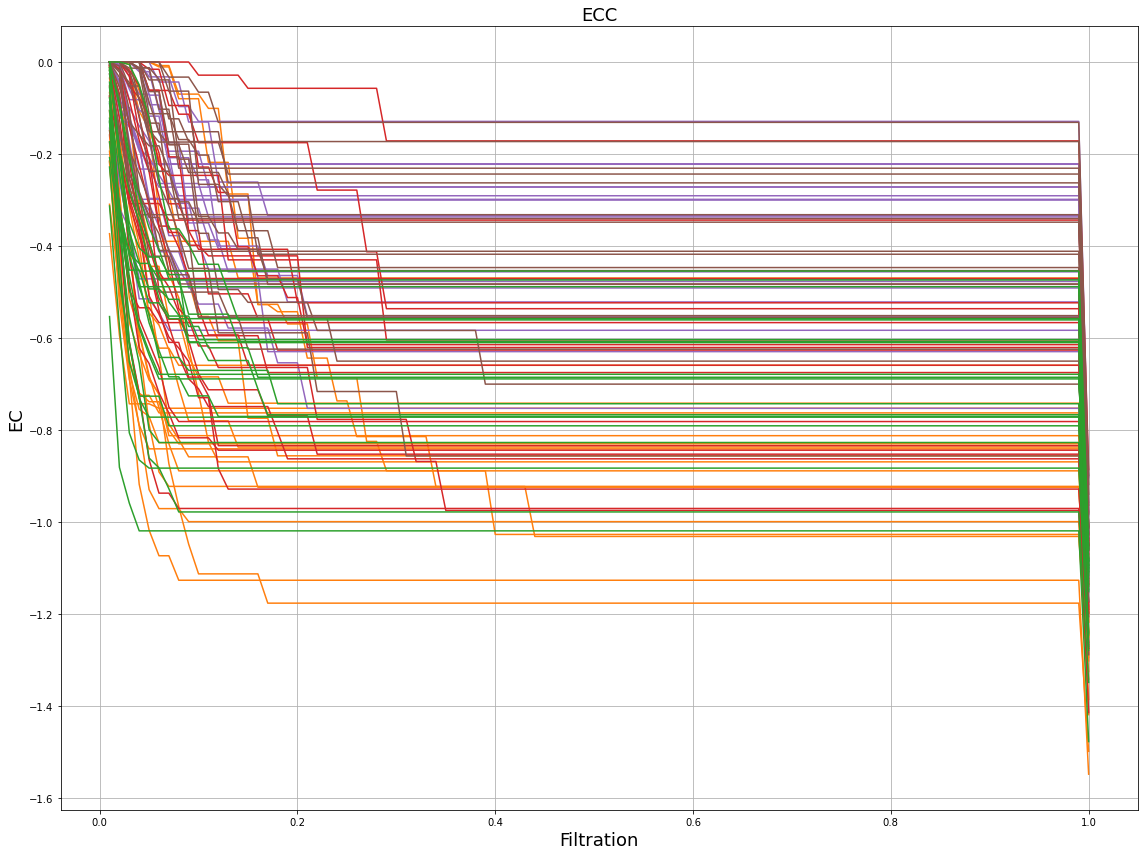

In [53]:
from matplotlib import pyplot as plt

# Plot ECC
plt.close('all')
plt.figure(figsize=(16,12))

cmap = plt.get_cmap("tab10")

for idx in range(1, 5000, 50):
    data = vec_ECC[idx-1]
    
    plt.plot(data[:, 0], data[:, 1], 
                 label='{}'.format(idx),
                 color = cmap(graph_classes.loc[idx-1].label))

plt.xlabel('Filtration', fontsize=18)
plt.ylabel('EC', fontsize=18)
plt.title('ECC', fontsize=18)
plt.grid()
#plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig("CV_eta.pdf")
# files.download("CV_eta.pdf")
plt.show()

In [61]:
np.savetxt("vectorize_ECC.csv", vec_ECC[: , : , 1], delimiter=",")

In [64]:
np.savetxt("labels.csv", graph_classes.label.values, delimiter=",")

# REDDIT 12k

In [12]:
import numpy as np
import pandas as pd

In [13]:
# which graph each node belongs
graph_idx_12 = pd.read_csv("datasets/REDDIT-MULTI-12K/REDDIT-MULTI-12K_graph_indicator.txt", 
                        names=["graph_idx"], header=None)
graph_idx_12.index = np.arange(1, len(graph_idx_12)+1)
graph_idx_12.index.rename('node_id', inplace=True)
graph_idx_12

,graph_idx
node_id,
1,1
2,1
3,1
4,1
5,1
...,...
4669112,11929
4669113,11929
4669114,11929


In [14]:
# each graph class (1 to 5)
graph_classes_12 = pd.read_csv("datasets/REDDIT-MULTI-12K/REDDIT-MULTI-12K_graph_labels.txt", 
                            names=["label"], header=None)
graph_classes_12.index = np.arange(1, len(graph_classes)+1)
graph_classes_12.index.rename('graph_id', inplace=True)
graph_classes_12

,label
graph_id,
1,6
2,6
3,6
4,6
5,6
...,...
11925,10
11926,10
11927,10


In [15]:
# edge list
graph_edges_12 = pd.read_csv("datasets/REDDIT-MULTI-12K/REDDIT-MULTI-12K_A.txt", 
                          names=["n1", "n2"], header=None)
#graph_edges.index.rename('graph_id', inplace=True)
graph_edges_12

,n1,n2
0,1,41
1,41,1
2,1,57
3,57,1
4,2,29
...,...,...
21800967,4668917,4669115
21800968,4669115,4669069
21800969,4669069,4669115
21800970,4669116,4668802


## For each graph, save its edges in a separate file

In [16]:
# create a dict to store the adj list of each graph
graphs_dict_12 = graph_classes_12.to_dict(orient='index')
for key in graphs_dict_12:
    graphs_dict_12[key]['edges'] = []

In [17]:
len(graph_edges_12)

21800972

In [18]:
for row in tqdm(graph_edges_12.itertuples()):
    graphs_dict_12[graph_idx_12.loc[row[1]][0]]['edges'].append([row.n1, row.n2])

21800972it [26:16:51, 230.43it/s] 


In [27]:
import pickle
pickle.dump( graphs_dict_12, open( "graphs_dict_12k.pkl", "wb" ) )

In [28]:
graphs_dict_12.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22